In [2]:
import numpy as np
import matplotlib.pyplot as plt

0.00: 0.00 
0.05: 2.75 6.04 
0.10: 3.15 8.80 6.93 
0.15: 3.42 9.22 9.60 7.48 
0.20: 3.62 9.53 10.08 10.23 7.95 
0.25: 3.79 9.63 10.27 10.62 10.70 8.30 
0.30: 3.93 9.82 10.55 10.96 11.11 11.05 8.70 
0.35: 4.05 9.98 10.64 11.04 11.42 11.39 11.35 8.76 
0.40: 4.16 10.14 10.85 11.25 11.58 11.68 11.78 11.42 9.10 
0.45: 4.26 10.15 11.00 11.36 11.73 11.85 12.07 11.93 11.87 9.36 
0.50: 4.35 10.28 10.97 11.59 11.85 12.01 12.25 12.20 12.13 12.09 9.50 
0.55: 4.44 10.33 11.05 11.65 12.00 12.26 12.41 12.38 12.46 12.47 12.22 9.69 
0.60: 4.51 10.45 11.15 11.73 12.04 12.26 12.59 12.52 12.67 12.75 12.70 12.39 9.89 
0.65: 4.59 10.56 11.42 11.82 12.23 12.45 12.65 12.73 12.81 12.91 12.89 12.79 12.62 9.91 
0.70: 4.66 10.65 11.37 11.94 12.30 12.50 12.79 12.87 13.00 13.07 13.13 13.05 13.02 12.71 10.15 
0.75: 4.72 10.62 11.45 12.00 12.44 12.63 12.92 12.97 13.17 13.23 13.25 13.22 13.22 13.15 12.92 10.06 
0.80: 4.78 10.84 11.57 12.00 12.53 12.64 12.98 13.02 13.21 13.32 13.38 13.37 13.41 13.45 13.34 12.73 10.04 


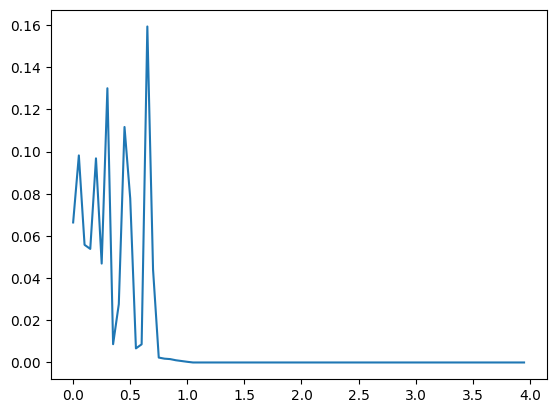

In [19]:
states = np.arange(0, 4.0, 0.05)
actions = np.arange(0, 4.0, 0.05)

T = 2
Q = np.zeros([T, round(4 / 0.05), round(4 / 0.05)])
epsilon = 0.15
om_q = 0.55
om_mu = 0.85
gamma = 0.2
rho = 0.95
C = 3

mu = np.ones([T, len(actions)])

for t in range(T):
    for i in range(len(actions)):
        mu[t, i] = mu[t, i] / len(actions)

# idk about this factor (gamma in the pseudocode), a value was not mentioned in their description
discount = 0.95

# given white noise process with specific supports and probabilities
supp_W = [0.9, 1.3]
pmf_W = [0.75, 0.25]

# calculate expectation of white noise process 
exp_W_gamma = 0
for i in range(len(supp_W)):
    exp_W_gamma += np.pow(supp_W[i], gamma) * pmf_W[i]

# calculate rho * expectation [W ^ gamma]
pEWgamma = rho * exp_W_gamma

# white noise with two outcomes with probabilities established above
def W ():
    return np.random.choice(supp_W, p = pmf_W)

# given state/action (by index) and mean field investment
# return through G(mu, W()) * a (amount invested)
# the new state (rounded)
# and using formula for utility calculate reward
def env (state, action, mu):
    consump = states[state] - actions[action]
    wealth = actions[action] * W() * C / (pEWgamma * (1 + (C - 1) * np.pow(mu, 3)))
    newState = round(20 * wealth)
    utility = np.pow(consump, gamma) / gamma
    return { 'x': newState, 'u': utility }

# rho calculator, given we are on the kth episode and
# have visited the specific state/action/time pair count_txa times

def rhosCalc(count_txa, k):
    '''does this have a counter incrementing?'''
    rhoQ = 1 / np.pow(1 + count_txa, om_q)
    rhoMu = 1 / np.pow(2 + k, om_mu)
    return { 'q': rhoQ, 'mu': rhoMu }

# eps-greedy policy, takes in 1d array of Q matrix specified by state and time, and state (index)
# if Unif[0, 1] > epsilon, choose argmax on 1d array of Q matrix, limited by state
# if Unif[0, 1] < epsilon, choose random action, limited by state (unif distribution)
def epsAction (Q_x, state):
    if np.random.random() > epsilon:
        maxim = max(Q_x[:state + 1])
        ind = []
        for i in range(0, state + 1):
            if maxim == Q_x[i]:
                ind.append(i)
        return ind[np.random.randint(0, len(ind))]
    else:
        return np.random.choice(list(range(state + 1)))

# initialize count for finding rho_Q (learning rate)
count_txa = np.zeros([T, len(states), len(actions)])


num_episodes = 200000

# Learning loop
for k in range(num_episodes):

    # Sample initial state 
    x_idx = np.random.choice(list(range(0, 21)))
    
    # Episode loop over time periods
    for t in range(T):
        
        # Ensure valid state
        if x_idx >= len(states) or x_idx < 0:
            break
            
        # Current Q values at t
        Q_xt = Q[t, x_idx, :]
        
        # Select action
        a_idx = epsAction(Q_xt, x_idx)
        
        # Skip if action exceeds state 
        if a_idx > x_idx:
            print("act > stat")
            a_idx = x_idx  #Invest everything instead of breaking
        
        # Get mean field investment at current time
        mu_t = np.dot(mu[t], actions)
        
        #call to environment
        result = env(x_idx, a_idx, mu_t)
        next_x_idx = result['x']
        reward = result['u']
        
        # Check next state is within the state space
        next_x_idx = min(max(next_x_idx, 0), len(states) - 1)
        
        # Calculate target
        if t < T - 1:
            if next_x_idx > 0:
                max_next_Q = discount * np.max(Q[t + 1, next_x_idx, :next_x_idx + 1])
            else:
                max_next_Q = discount * Q[t + 1, 0, 0]
            td_target = reward + max_next_Q
        else:
            #end state
            td_target = reward + rho * np.pow(states[next_x_idx], gamma) / gamma

        # target for mean field
        a_target = np.zeros(len(actions))
        a_target[a_idx] = 1
        
        # Update count for learning rate
        count_txa[t, x_idx, a_idx] += 1
        
        # Calculate learning rates
        rhos = rhosCalc(count_txa[t, x_idx, a_idx], k)
        rho_Q = rhos['q']
        rho_Mu = rhos['mu']
        
        # Q-learning update
        Q[t, x_idx, a_idx] = Q[t, x_idx, a_idx] + rho_Q * (td_target - Q[t, x_idx, a_idx])
        
        # Mean field distribution update
        mu[t, :] = mu[t, :] + rho_Mu * (a_target - mu[t, :])

        # Move to next state
        x_idx = next_x_idx

for x in range(80):
    print("%4.2f: " % (states[x]), end = '')
    for a in range(x + 1):
        print("%4.2f " % (Q[0, x, a]), end = '')

    print("")

# argmaxxing to find optimal policy for each state
# and plotting to see trend
optimal = [[], []]
for x in range(80):
    optimal[0].append(actions[np.argmax(Q[0, x, :])])
    optimal[1].append(actions[np.argmax(Q[1, x, :])])



%matplotlib inline

#plt.plot(states, optimal[0])
#plt.plot(states, optimal[1])
plt.plot(actions, mu[0])

0.34154957434525623


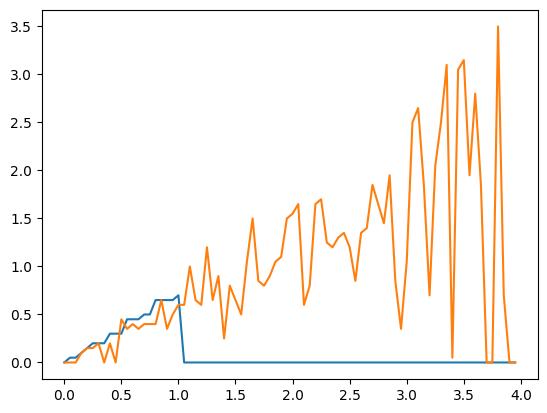

In [21]:
print(np.dot(mu[0], actions))

%matplotlib inline

plt.plot(states, optimal[0])
plt.plot(states, optimal[1])